# Feature Importance with Ensembles

In [34]:
# Imports
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.inspection import permutation_importance
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Step 0 -- Data Exploration & Preprocessing (copy)

In [2]:
# Penguin dataset
data_penguins = sns.load_dataset("penguins").dropna()
X_penguins = data_penguins.drop(columns="species")
y_penguins = data_penguins["species"]
X_penguins = pd.get_dummies(X_penguins) # one-hot encode categorical features

# Student performance dataset
data_students = fetch_ucirepo(id=320) 
X_students = data_students.data.features 
Y_students = data_students.data.targets 
X_students = pd.get_dummies(X_students) # one-hot encode categorical features

# Digits dataset
data_digits = load_digits()
X_digits = data_digits.data
y_digits = data_digits.target

# Step 1 -- Feature Importance with Ensembles

We'll estimate feature importance using Random Forests.  
These models provide built-in **impurity-based feature importances**, and we can also estimate **permutation importances** afterward.

## Step 1.1 -- Impurity-based feature importance

#### Penguins

In [35]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_penguins, y_penguins, random_state=42)

In [36]:
# Train a random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
# Verify that the model works

# Stupid baseline: always predicts the most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
baseline_acc = accuracy_score(y_test, dummy_clf.predict(X_test))

# Model
model_acc = accuracy_score(y_test, clf.predict(X_test))

print(f"Baseline accuracy: {baseline_acc:.3f}")
print(f"Random Forest accuracy: {model_acc:.3f}")

Baseline accuracy: 0.476
Random Forest accuracy: 0.988


<div style="border: 1px solid rgb(0, 0, 0); background-color:rgb(224, 179, 83); padding: 10px; border-radius: 5px; color: white;">
<b>❓ Question:</b> Why do we need to verify that the model works before looking at the feature importances?
</div>

In [41]:
# Extract feature importances
penguin_impurity_importances = clf.feature_importances_
feature_names = X_penguins.columns
indices = np.argsort(penguin_impurity_importances)[::-1]

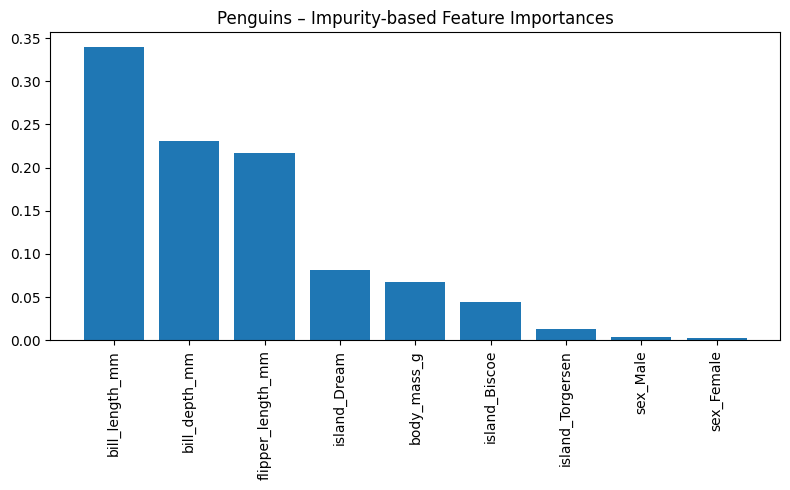

In [ ]:
# Plot impurity-based feature importances
plt.figure(figsize=(8, 5))
plt.bar(range(len(penguin_impurity_importances)), penguin_impurity_importances[indices])
plt.xticks(range(len(penguin_impurity_importances)), feature_names[indices], rotation=90)
plt.title("Penguins – Impurity-based Feature Importances")
plt.tight_layout()
plt.show()

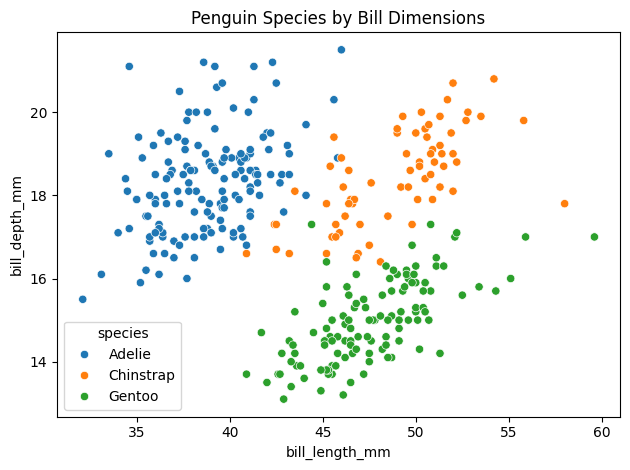

In [10]:
# Sanity check: Do the most important features separate the classes well?
sns.scatterplot(
    data=data_penguins,
    x="bill_length_mm",
    y="bill_depth_mm",
    hue="species",
)
plt.title("Penguin Species by Bill Dimensions")
plt.tight_layout()
plt.show()

#### Student Performance

In [19]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_students, Y_students, random_state=42)

# Train multi-target regressor
reg = RandomForestRegressor(random_state=42, n_estimators=500)
reg.fit(X_train, y_train)

# Baseline: Always predicts the average grade
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)

# Evaluate
baseline_mse = mean_squared_error(y_test, dummy_reg.predict(X_test))
model_mse = mean_squared_error(y_test, reg.predict(X_test))

print(f"Baseline Mean-Squared-Error: {baseline_mse:.3f}")
print(f"Random Forest Mean-Squared-Error: {model_mse:.3f}")

Baseline Mean-Squared-Error: 9.564
Random Forest Mean-Squared-Error: 7.713


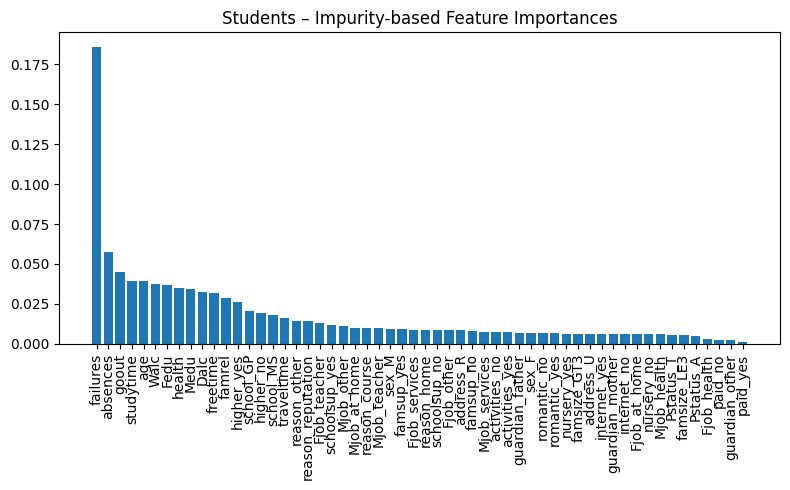

In [14]:
# Mean importances across targets
students_impurity_importances = reg.feature_importances_
feature_names = X_students.columns
indices = np.argsort(students_impurity_importances)[::-1]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(range(len(students_impurity_importances)), students_impurity_importances[indices])
plt.xticks(range(len(students_impurity_importances)), feature_names[indices], rotation=90)
plt.title("Students – Impurity-based Feature Importances")
plt.tight_layout()
plt.show()

#### Digits

In [21]:
# Training/test split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

# Model
clf_digits = RandomForestClassifier(random_state=42)
clf_digits.fit(X_train, y_train)

# Baseline
dummy_digits = DummyClassifier(strategy="most_frequent")
dummy_digits.fit(X_train, y_train)

# Evaluate
baseline_acc = accuracy_score(y_test, dummy_digits.predict(X_test))
model_acc = accuracy_score(y_test, clf_digits.predict(X_test))

print(f"Baseline accuracy: {baseline_acc:.3f}")
print(f"Random Forest accuracy: {model_acc:.3f}")

Baseline accuracy: 0.082
Random Forest accuracy: 0.971


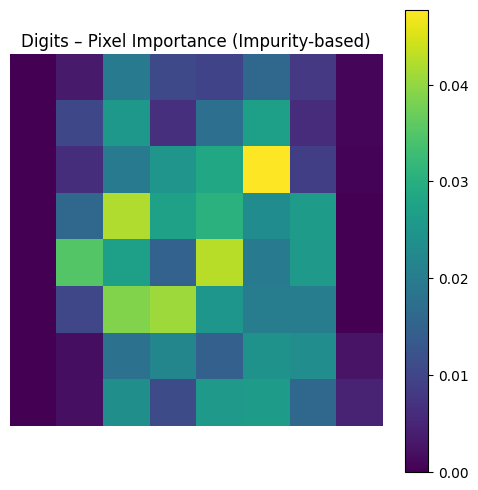

In [22]:
# Get importances (pixels)
digits_impurity_importances = clf_digits.feature_importances_

# Plot importances
plt.figure(figsize=(6, 6))
plt.imshow(digits_impurity_importances.reshape(8, 8), cmap="viridis")
plt.title("Digits – Pixel Importance (Impurity-based)")
plt.colorbar()
plt.axis("off")
plt.show()

<div style="border: 1px solid rgb(0, 0, 0); background-color:rgb(224, 179, 83); padding: 10px; border-radius: 5px; color: white;">
<b>❓ Question:</b> What about class-wise importances?
</div>

#### SPOILER: Class-wise importances

RandomForest natively does not support this, so we need a work-around...

OneVsRestClassifier turns a multiclass classification problem into multiple binary classification problems.
For a problem with K classes, it trains K separate classifiers (and each of them has feature importance).
Each classifier learns to distinguish one class vs. all other classes ("one-vs-rest").
During prediction, all K classifiers produce scores, and the class with the highest score is selected.

In [32]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

# One-vs-Rest Random Forest
clf_ovr = OneVsRestClassifier(RandomForestClassifier(random_state=42))
clf_ovr.fit(X_train, y_train)

# Evaluate
y_pred = clf_ovr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"One-vs-Rest Random Forest accuracy: {accuracy:.3f}")

One-vs-Rest Random Forest accuracy: 0.976


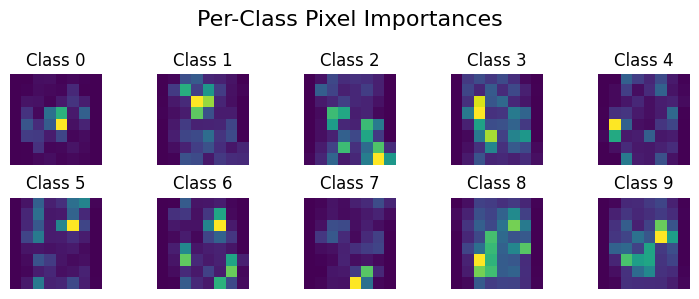

In [33]:
# Plot class-wise feature importance
n_classes = len(clf_ovr.classes_)
n_cols = 5
n_rows = int(np.ceil(n_classes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(1.5 * n_cols, 1.5 * n_rows))

for i, est in enumerate(clf_ovr.estimators_):
    ax = axes[i // n_cols, i % n_cols]
    importances = est.feature_importances_.reshape(8, 8)
    im = ax.imshow(importances, cmap="viridis")
    ax.set_title(f"Class {clf_ovr.classes_[i]}")
    ax.axis("off")

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    axes[j // n_cols, j % n_cols].axis("off")

fig.suptitle("Per-Class Pixel Importances", fontsize=16)
plt.tight_layout()
plt.show()

## Step 1.2 -- Permutation importances

While impurity-based feature importances come from how much a feature reduces node impurity during training, **permutation importance** measures how much a feature matters to model performance after training.

**Idea**: If a feature is important, shuffling its values should make predictions worse.

Advantages:
- Model-agnostic
- Evaluated on test data → reflects generalization
- Can be used for individual classes (with care)

Limitations:
- More computationally expensive
- Sensitive to correlated features


#### Penguin

In [43]:
# Split & fit
X_train, X_test, y_train, y_test = train_test_split(X_penguins, y_penguins, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [50]:
# Permutation importance on test set
penguin_permutation_importances = permutation_importance(clf, X_test, y_test, n_repeats=100, random_state=42)

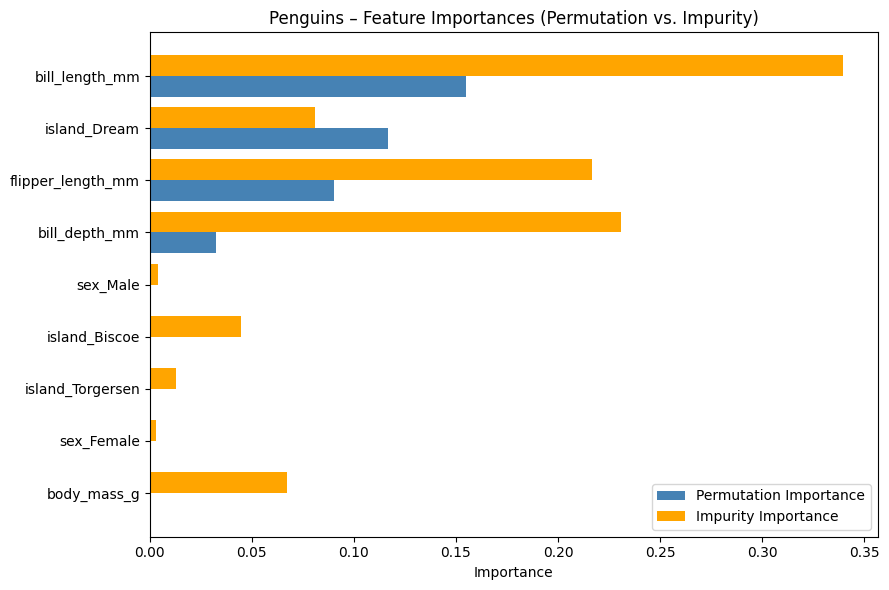

In [51]:
# Both importance sources, aligned by feature name
feature_names = X_train.columns
perm = penguin_permutation_importances.importances_mean
impurity = penguin_impurity_importances  # precomputed
sorted_idx = np.argsort(perm)

# Bar positions
y_pos = np.arange(len(feature_names))
bar_width = 0.4

plt.figure(figsize=(9, 6))
plt.barh(y_pos - bar_width/2, perm[sorted_idx], height=bar_width, label="Permutation Importance", color="steelblue")
plt.barh(y_pos + bar_width/2, impurity[sorted_idx], height=bar_width, label="Impurity Importance", color="orange")

plt.yticks(y_pos, feature_names[sorted_idx])
plt.xlabel("Importance")
plt.title("Penguins – Feature Importances (Permutation vs. Impurity)")
plt.legend()
plt.tight_layout()
plt.show()

<div style="border: 1px solid rgb(0, 0, 0); background-color:rgb(224, 179, 83); padding: 10px; border-radius: 5px; color: white;">
<b>🔧 Task:</b> Calculate permutation feature importance for the other datasets.
</div>

In [53]:
# your code
...